## Яндекс Практикум, курс "Инженер Машинного Обучения" (04/2024 г.)
## Проект 2-го спринта: "Улучшение baseline-модели"

__Содержание:__

* [Этап 2: Проведение EDA](#step_2)
* [Этап 3: Генерация признаков и обучение модели](#step_3)
* [Этап 4: Отбор признаков и обучение новой версии модели](#step_4)
* [Этап 5: Подбор гиперпараметров и обучение новой версии модели](#step_5)

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import psycopg2 as psycopg
from sqlalchemy import create_engine
from datetime import datetime
import time

from category_encoders import CatBoostEncoder
from catboost import CatBoostRegressor

import mlflow
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

from collections import defaultdict
from statistics import median

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
    FunctionTransformer
)

from autofeat import AutoFeatRegressor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import optuna
from optuna.integration.mlflow import MLflowCallback

Загружаем переменные окружения

In [2]:
load_dotenv()

True

### Этап 2: Проведение EDA <a id="step_2"></a>

После выполнения EDA логируем его результаты, включая ноутбук с кодом notebook_eda.ipynb и md-файл с выводами conclusions_eda.md

In [6]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 

TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 

EXPERIMENT_NAME = 'mle-project-sprint-2'
RUN_NAME = 'step_2'

In [7]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact("notebook_eda.ipynb", "eda")
    mlflow.log_artifact("conclusions_eda.md", "eda")

In [8]:
print(run_id)

run = mlflow.get_run(run_id)
assert run.info.status == 'FINISHED'

dda6cd831cf14ed3a90b275be16cdc63


__Выводы по результатам 2-го этапа__

См. файлы notebook_eda.ipynb или conclusions_eda.md.

### Этап 3: Генерация признаков и обучение модели <a id="step_3"></a>

__Извлекаем очищенные данные__

In [3]:
# Загружаем параметры подключения к БД из переменных окружения
username = os.environ.get('DB_DESTINATION_USER')
password = os.environ.get('DB_DESTINATION_PASSWORD')
host = os.environ.get('DB_DESTINATION_HOST')
port = os.environ.get('DB_DESTINATION_PORT')
db = os.environ.get('DB_DESTINATION_NAME')

In [4]:
# Создаем соединение к БД
conn = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{db}', connect_args={'sslmode':'require'})

In [5]:
# Скачиваем очищенные данные из таблицы clean_flats_dataset в датафрейм
data = pd.read_sql('select * from clean_flats_dataset', conn, index_col='flat_id')

In [6]:
data.head()

,id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
flat_id,,,,,,,,,,,,,,,,,
8348,23114,8,10.6,56.000000,3,False,False,88.599998,10990000,2018,4,55.542187,37.483067,2.64,409,18,True
8350,23116,3,7.0,28.000000,2,False,False,44.700001,8999000,1967,4,55.857765,37.422684,2.64,143,9,True
8351,23118,16,10.9,54.799999,4,False,False,89.099998,24000000,1996,4,55.562908,37.570431,2.70,164,16,True
8352,23120,2,7.4,66.300003,4,False,False,93.000000,17500000,1965,1,55.653507,37.649426,2.70,59,6,True
8354,23122,4,9.1,17.700001,1,False,False,34.000000,7500000,1964,1,55.796406,37.459873,3.00,72,9,True


Выполняем ту же предобработку, что и в проекте 1-го спринта

In [7]:
# Вместо года постройки добавляем возраст здания
data['building_age'] = (datetime.now().year - data['build_year']).astype('float')

# Удаляем лишние колонки (studio является константным признаком, см. EDA)
data.drop(
    columns=['id', 'build_year', 'studio'], 
    inplace=True
)

# Изменяем тип целочисленных признаков rooms и building_type_int на object, чтобы работать с ними как с категориальными
data[['rooms', 'building_type_int']] = data[['rooms', 'building_type_int']].astype('object')

# Изменяем тип целых колонок на float, чтобы все числовые признаки относились к одному типу
num_int_cols = data.select_dtypes('int').columns
data[num_int_cols] = data[num_int_cols].astype('float') 

__Генерируем новые признаки и обучаем модель__

Разделяем данные на обучающую и тестовую выборки

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.drop('price')],
                                                    data['price'], 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

Группируем признаки по типам

In [9]:
cat_features = X_train.select_dtypes(include=['bool', 'object'])
is_bin_cat_features = cat_features.nunique() == 2
bin_cat_features = cat_features[is_bin_cat_features[is_bin_cat_features].index]
other_cat_features = cat_features[is_bin_cat_features[~is_bin_cat_features].index]
num_features = X_train.select_dtypes(include=['float'])

Создаем энкодеры для кодирования существующих и генерации новых признаков

In [10]:
# Для бинарных категориальных признаков
encoder_oh = OneHotEncoder(
    categories='auto',
    handle_unknown='ignore', 
    sparse_output=False,
    drop='if_binary'
) 

# Для небинарных категориальных признаков
encoder_cb = CatBoostEncoder(random_state=42)

# Для генерации новых числовых признаков
encoder_pol = PolynomialFeatures(
    degree=2,
    include_bias=False
)

# Для генерации новых числовых признаков
encoder_q = QuantileTransformer(
    n_quantiles=100,
    random_state=42
)

# Для генерации новых числовых признаков: применяем к каждому числовому признаку функцию log(1+x) один раз
encoder_afr = AutoFeatRegressor(
    transformations=('1+', 'log'),
    feateng_steps=1,
    n_jobs=-1
)

Создаем основной трансформер данных с autofeat (его мы объединим в один пайплайн с моделью)

In [11]:
# Применяем выбранные преобразования к числовым признакам (в т.ч. autofeat)
num_preproc_w_afr = ColumnTransformer(
    [
        ('num_pol', encoder_pol, num_features.columns.tolist()),
        ('num_q', encoder_q, num_features.columns.tolist()),
        ('num_afr', encoder_afr, num_features.columns.tolist()) 
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
)

# Нормализуем числовые признаки после их преобразования.
# На выходе полиномиального энкодера будут в т.ч. исходные числовые признаки, им соответствует степень 1
num_pipeline_w_afr = Pipeline(
    [
        ('num_preproc_w_afr', num_preproc_w_afr),
        ('num_sc', StandardScaler())
    ]
)

# Добавляем к числовому пайплайну энкодеры категориальных признаков
preproc_w_afr = ColumnTransformer(
    [
        ('bin_cat', encoder_oh, bin_cat_features.columns.tolist()),
        ('other_cat', encoder_cb, other_cat_features.columns.tolist()),
        ('num_pipeline_w_afr', num_pipeline_w_afr, num_features.columns.tolist())
        
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
)

Создаем вспомогательный трансформер данных без autofeat (чтобы воспользоваться get_features_names_out, когда будем сохранять преобразованные признаки вместе с их именами)

In [12]:
# Применяем выбранные преобразования к числовым признакам (исключая autofeat)
num_preproc_wo_afr = ColumnTransformer(
    [
        ('num_pol', encoder_pol, num_features.columns.tolist()),
        ('num_q', encoder_q, num_features.columns.tolist())
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
)

# Нормализуем числовые признаки после их преобразования.
# На выходе полиномиального энкодера будут в т.ч. исходные числовые признаки, им соответствует степень 1
num_pipeline_wo_afr = Pipeline(
    [
        ('num_preproc_wo_afr', num_preproc_wo_afr),
        ('num_sc', StandardScaler())
    ]
)

# Добавляем к числовому пайплайну энкодеры категориальных признаков
preproc_wo_afr = ColumnTransformer(
    [
        ('bin_cat', encoder_oh, bin_cat_features.columns.tolist()),
        ('other_cat', encoder_cb, other_cat_features.columns.tolist()),
        ('num_pipeline_wo_afr', num_pipeline_wo_afr, num_features.columns.tolist())
        
    ],
    remainder='drop',
    verbose_feature_names_out=True,
    n_jobs=-1
)

Создаем пайплайн из модели и основного трансформера, включающего autofeat

In [13]:
model = CatBoostRegressor(loss_function='MAPE', verbose=False, random_state=42)
  
pipeline = Pipeline(
    [
        ('preproc_w_afr', preproc_w_afr),
        ('model', model)
    ]
)

In [14]:
# Структура пайплайна
pipeline

Pipeline(steps=[('preproc_w_afr',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('bin_cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['is_apartment',
                                                   'has_elevator']),
                                                 ('other_cat',
                                                  CatBoostEncoder(random_state=42),
                                                  ['rooms',
                                                   'building_type_int']),
                                                 ('num_pipeline_w_afr',
                                                  Pipeline(steps=[('num_preproc_w_afr',
                                                                   ColumnTransformer(n...
                                                                                                     'living_area',
                                                                                                     'total_area',
                                                                                                     'latitude',
                                                                                                     'longitude',
                                                                                                     'ceiling_height',
                                                                                                     'flats_count',
                                                                                                     'floors_total',
                                                                                                     'building_age'])])),
                                                                  ('num_sc',
                                                                   StandardScaler())]),
                                                  ['floor', 'kitchen_area',
                                                   'living_area', 'total_area',
                                                   'latitude', 'longitude',
                                                   'ceiling_height',
                                                   'flats_count',
                                                   'floors_total',
                                                   'building_age'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f037d1643a0>)])

Запускаем пайплайн на обучающих данных

In [15]:
start = time.time()
pipeline.fit(X_train, y_train)
end = time.time()

/home/mle-user/mle_projects/mle-mlflow/.venv_mle_mlflow/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


Оцениваем модель на тестовых данных

In [16]:
y_pred = pipeline.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

metrics = {}
metrics['MAPE'] = mape
metrics['fit_time'] = end - start
print(metrics)

{'MAPE': 1.225445433359022, 'fit_time': 76.67032814025879}


__Сохраняем преобразованные данные для логирования в MLflow и использования на последующих этапах__

In [17]:
# Признаки, сгенерированные без autofeat (на выходе будет ndarray)
encoded_X_train_wo_afr = preproc_wo_afr.fit_transform(X_train, y_train) 
encoded_X_test_wo_afr = preproc_wo_afr.transform(X_test)

# Превращаем их в dataframe
encoded_X_train_wo_afr = pd.DataFrame(
    encoded_X_train_wo_afr, 
    columns=preproc_wo_afr.get_feature_names_out()
) 

encoded_X_test_wo_afr = pd.DataFrame(
    encoded_X_test_wo_afr, 
    columns=preproc_wo_afr.get_feature_names_out()
)

In [18]:
# Смотрим, что получилось
encoded_X_train_wo_afr.head()

,bin_cat__is_apartment_True,bin_cat__has_elevator_True,other_cat__rooms,other_cat__building_type_int,num_pipeline_wo_afr__num_pol__floor,num_pipeline_wo_afr__num_pol__kitchen_area,num_pipeline_wo_afr__num_pol__living_area,num_pipeline_wo_afr__num_pol__total_area,num_pipeline_wo_afr__num_pol__latitude,num_pipeline_wo_afr__num_pol__longitude,...,num_pipeline_wo_afr__num_q__floor,num_pipeline_wo_afr__num_q__kitchen_area,num_pipeline_wo_afr__num_q__living_area,num_pipeline_wo_afr__num_q__total_area,num_pipeline_wo_afr__num_q__latitude,num_pipeline_wo_afr__num_q__longitude,num_pipeline_wo_afr__num_q__ceiling_height,num_pipeline_wo_afr__num_q__flats_count,num_pipeline_wo_afr__num_q__floors_total,num_pipeline_wo_afr__num_q__building_age
0,0.0,1.0,1.274040e+07,1.274040e+07,-1.052174,-0.692780,-0.299733,-0.847382,1.588429,-0.438656,...,-1.192165,-1.054159,-0.301378,-1.039578,1.648781,-0.496144,-1.519512,-1.242884,-0.181963,0.792346
1,0.0,1.0,1.107020e+07,1.274040e+07,0.055965,-0.692780,-0.063449,-0.491669,-0.422046,0.851233,...,0.308035,-1.054159,-0.161198,-0.394518,-0.440684,0.932541,-0.505474,0.775025,-0.866801,0.511058
2,0.0,1.0,1.001347e+07,1.032020e+07,-0.608918,-0.366908,-1.886207,-0.240921,0.530116,-0.070656,...,-0.544351,-0.553734,-1.650011,-0.048742,0.528656,0.025349,0.633094,-0.184500,-0.866801,0.915409
3,0.0,1.0,1.213510e+07,1.274040e+07,-1.052174,2.240064,1.151722,1.024484,-0.262148,-0.614266,...,-1.192165,1.689550,1.276860,1.139680,-0.251038,-0.724741,1.718292,1.603705,1.012112,-1.018440
4,0.0,1.0,1.542808e+07,1.304680e+07,0.499221,-0.725367,-0.002691,-0.480007,-1.143133,-0.044685,...,0.751275,-1.295743,-0.104803,-0.371272,-1.255525,0.077451,-0.505474,0.129527,-0.866801,0.686863


In [19]:
# Имена новых признаков без использования autofeat
print(preproc_wo_afr.get_feature_names_out())

['bin_cat__is_apartment_True' 'bin_cat__has_elevator_True'
 'other_cat__rooms' 'other_cat__building_type_int'
 'num_pipeline_wo_afr__num_pol__floor'
 'num_pipeline_wo_afr__num_pol__kitchen_area'
 'num_pipeline_wo_afr__num_pol__living_area'
 'num_pipeline_wo_afr__num_pol__total_area'
 'num_pipeline_wo_afr__num_pol__latitude'
 'num_pipeline_wo_afr__num_pol__longitude'
 'num_pipeline_wo_afr__num_pol__ceiling_height'
 'num_pipeline_wo_afr__num_pol__flats_count'
 'num_pipeline_wo_afr__num_pol__floors_total'
 'num_pipeline_wo_afr__num_pol__building_age'
 'num_pipeline_wo_afr__num_pol__floor^2'
 'num_pipeline_wo_afr__num_pol__floor kitchen_area'
 'num_pipeline_wo_afr__num_pol__floor living_area'
 'num_pipeline_wo_afr__num_pol__floor total_area'
 'num_pipeline_wo_afr__num_pol__floor latitude'
 'num_pipeline_wo_afr__num_pol__floor longitude'
 'num_pipeline_wo_afr__num_pol__floor ceiling_height'
 'num_pipeline_wo_afr__num_pol__floor flats_count'
 'num_pipeline_wo_afr__num_pol__floor floors_total

In [20]:
# Признаки, полученные только с помощью autofeat
encoded_X_train_afr = encoder_afr.fit_transform(X_train[num_features.columns].values, y_train.values)
encoded_X_test_afr = encoder_afr.transform(X_test[num_features.columns].values)

/home/mle-user/mle_projects/mle-mlflow/.venv_mle_mlflow/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


In [21]:
# Смотрим, что получилось при использовании autofeat
encoded_X_train_afr.head()

,x000,x001,x002,x003,x004,x005,x006,x007,x008,x009
0,2.0,6.0,23.5,37.900002,55.891251,37.538116,2.50,82.0,12.0,55.0
1,7.0,6.0,27.0,44.000000,55.685341,37.728146,2.64,287.0,9.0,52.0
2,4.0,7.0,0.0,48.299999,55.782860,37.592331,2.70,179.0,9.0,56.0
3,2.0,15.0,45.0,70.000000,55.701717,37.512245,3.00,512.0,17.0,19.0
4,9.0,5.9,27.9,44.200001,55.611488,37.596157,2.64,211.0,9.0,54.0


In [22]:
# Объединяем все признаки
encoded_X_train = pd.concat([encoded_X_train_wo_afr, encoded_X_train_afr], axis=1)
encoded_X_test = pd.concat([encoded_X_test_wo_afr, encoded_X_test_afr], axis=1)

In [ ]:
# Добавляем целевую переменную и записываем в файлы датасеты train и test с преобразованными признаками

encoded_data_train = pd.concat([encoded_X_train, y_train], axis=1)
encoded_data_test = pd.concat([encoded_X_test, y_test], axis=1)

os.makedirs('../data', exist_ok=True)
encoded_data_train.to_csv('../data/encoded_data_train.csv')
encoded_data_test.to_csv('../data/encoded_data_test.csv')

__Логируем результаты в MLflow__

Устанавливаем параметры MLflow Tracking Server и MLflow Model Registry, а также идентификаторы эксперимента, запуска и модели
(сначала нужно поднять MLflow, для чего в терминале перейти в папку mlflow_server и выполнить в командной строке 
 команду "sh run_mlflow_server.sh")

In [58]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 

TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 

EXPERIMENT_NAME = 'mle-project-sprint-2'
RUN_NAME = 'step_3'
REGISTRY_MODEL_NAME = 'flats_price_model_sprint_2_step_3'

Оборачиваем пайплайн в класс CustomMlflowModel для логирования в MLflow

In [59]:
class CustomMlflowModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        super().__init__()
        self._model = model
    
    def predict(self, context, model_input):
        return self._model.predict(model_input)

In [60]:
custom_model = CustomMlflowModel(pipeline)

Логируем модель, энкодер autofeat, метрики и другие артефакты в MLflow

In [61]:
metadata = {'model_type': 'regression'}
pip_requirements = "../requirements.txt" 
signature = mlflow.models.infer_signature(
    X_test,
    pipeline.predict(X_test)
) 
input_example = data[:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("../data/encoded_data_train.csv", "data")
    mlflow.log_artifact("../data/encoded_data_test.csv", "data")
            
    model_info = mlflow.pyfunc.log_model( 
        python_model=custom_model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        pip_requirements=pip_requirements
    )
    
    afr_info = mlflow.sklearn.log_model(
        encoder_afr, 
        artifact_path="encoders",
        registered_model_name='encoder_afr_sprint_2_step_3'
    )

/home/mle-user/mle_projects/mle-mlflow/.venv_mle_mlflow/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Successfully registered model 'flats_price_model_sprint_2_step_3'.
2024/04/20 13:41:55 INFO mlflow.tracking._model_registry.client: Waiting 

In [62]:
print(run_id)

run = mlflow.get_run(run_id)
assert run.info.status == 'FINISHED'

85f646eecd7047b5ac5e253aa54bcf04


In [ ]:
# После логирования в MLflow удаляем файлы, сохраненные локально
os.remove('../data/encoded_data_train.csv')
os.remove('../data/encoded_data_test.csv')

__Выводы по результатам 3-го этапа__

Благодаря добавлению новых признаков ошибка MAPE на тестовых данных немного уменьшилась по сравнению с базовой моделью из 1-го этапа, время обучения при этом выросло.

### Этап 4: Отбор признаков и обучение новой версии модели <a id="step_4"></a>

Будем использовать преобразованные признаки из предыдущего этапа.

Создаем папку для хранения артефактов, относящихся к отбору признаков

In [24]:
FS_ASSETS_DIR = "fs_assets"
os.makedirs(f'../{FS_ASSETS_DIR}', exist_ok=True)

__Отбираем признаки с помощью метода Sequential Forward Floating Selection (SFFS)__

In [ ]:
model = CatBoostRegressor(
    iterations=100, 
    loss_function='MAPE', 
    eval_metric='MAPE', 
    verbose=False, 
    random_state=42
)

# Отбираем 10 признаков
sffs = SFS(
    estimator=model,
    forward=True,      
    floating=True,
    k_features=10,
    scoring='neg_mean_absolute_percentage_error',
    cv=2,               
    n_jobs=-1
) 

sffs = sffs.fit(encoded_X_train, y_train)
sffs_df = pd.DataFrame.from_dict(sffs.get_metric_dict()).T
sffs_df.to_csv(f"../{FS_ASSETS_DIR}/sffs.csv")

In [26]:
sffs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[-1.0089993284292074, -1.0001869723610202]",-1.004593,"(bin_cat__is_apartment_True,)",0.018958,0.004406,0.004406
2,"(0, 5)","[-1.0118975854902548, -0.966151559982494]",-0.989025,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",0.098415,0.022873,0.022873
3,"(0, 5, 24)","[-2.547134967491392, -0.9236339221042358]",-1.735384,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",3.492681,0.811751,0.811751
4,"(0, 5, 24, 27)","[-2.6701813677063337, -0.9682057326983584]",-1.819194,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",3.661505,0.850988,0.850988
5,"(0, 5, 24, 27, 28)","[-2.1940511245560335, -1.024232559958161]",-1.609142,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",2.516662,0.584909,0.584909
6,"(0, 2, 5, 24, 27, 28)","[-1.0718928511108359, -1.6105173920017146]",-1.341205,"(bin_cat__is_apartment_True, other_cat__rooms,...",1.158757,0.269312,0.269312
7,"(0, 1, 2, 5, 24, 27, 28)","[-1.0611523236225635, -1.639138395198876]",-1.350145,"(bin_cat__is_apartment_True, bin_cat__has_elev...",1.243437,0.288993,0.288993
8,"(0, 1, 2, 4, 5, 24, 27, 28)","[-1.4952851897128179, -4.998849928184432]",-3.247068,"(bin_cat__is_apartment_True, bin_cat__has_elev...",7.537311,1.751782,1.751782
9,"(0, 1, 4, 5, 23, 24, 27, 28, 32)","[-2.791747304775303, -1.3958228624016882]",-2.093785,"(bin_cat__is_apartment_True, bin_cat__has_elev...",3.003089,0.697962,0.697962
10,"(0, 1, 4, 5, 23, 24, 27, 28, 32, 80)","[-2.6473186116661003, -2.8095578627560873]",-2.728438,"(bin_cat__is_apartment_True, bin_cat__has_elev...",0.34903,0.08112,0.08112


In [27]:
print(sffs.k_score_)
print(sffs.k_feature_names_)
print(sffs.k_feature_idx_)

-2.728438237211094
('bin_cat__is_apartment_True', 'bin_cat__has_elevator_True', 'num_pipeline_wo_afr__num_pol__floor', 'num_pipeline_wo_afr__num_pol__kitchen_area', 'num_pipeline_wo_afr__num_pol__floor building_age', 'num_pipeline_wo_afr__num_pol__kitchen_area^2', 'num_pipeline_wo_afr__num_pol__kitchen_area latitude', 'num_pipeline_wo_afr__num_pol__kitchen_area longitude', 'num_pipeline_wo_afr__num_pol__kitchen_area building_age', 'x001')
(0, 1, 4, 5, 23, 24, 27, 28, 32, 80)


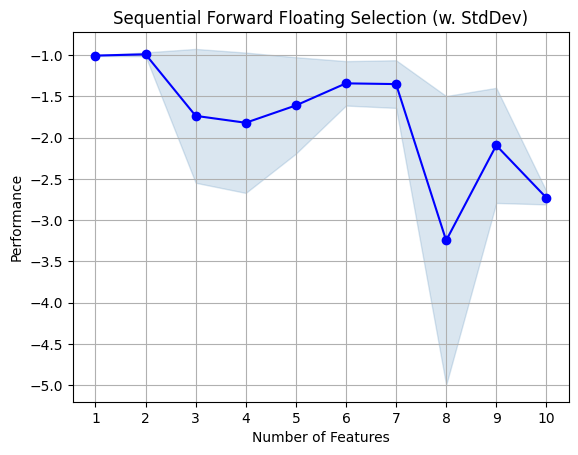

<Figure size 640x480 with 0 Axes>

In [28]:
# График отбора признаков для SFFS
fig = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Floating Selection (w. StdDev)')
plt.grid()
plt.show()
plt.savefig(f"../{FS_ASSETS_DIR}/sffs.png")

Из графика следует, что нет смысла брать более 6 первых признаков

In [30]:
sffs.k_feature_names_[:6]

('bin_cat__is_apartment_True',
 'bin_cat__has_elevator_True',
 'num_pipeline_wo_afr__num_pol__floor',
 'num_pipeline_wo_afr__num_pol__kitchen_area',
 'num_pipeline_wo_afr__num_pol__floor building_age',
 'num_pipeline_wo_afr__num_pol__kitchen_area^2')

__Отбираем признаки с помощью метода Sequential Forward Selection (SFS)__

In [ ]:
model = CatBoostRegressor(
    iterations=100, 
    loss_function='MAPE', 
    eval_metric='MAPE', 
    verbose=False, 
    random_state=42
)

# Отбираем 10 признаков
sfs = SFS(
    estimator=model,
    forward=True,      
    floating=False,
    k_features=10,
    scoring='neg_mean_absolute_percentage_error',
    cv=2,               
    n_jobs=-1
) 

sfs = sfs.fit(encoded_X_train, y_train)
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df.to_csv(f"../{FS_ASSETS_DIR}/sfs.csv")

In [32]:
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[-1.0089993284292074, -1.0001869723610202]",-1.004593,"(bin_cat__is_apartment_True,)",0.018958,0.004406,0.004406
2,"(0, 5)","[-1.0118975854902548, -0.966151559982494]",-0.989025,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",0.098415,0.022873,0.022873
3,"(0, 5, 24)","[-2.547134967491392, -0.9236339221042358]",-1.735384,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",3.492681,0.811751,0.811751
4,"(0, 5, 24, 27)","[-2.6701813677063337, -0.9682057326983584]",-1.819194,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",3.661505,0.850988,0.850988
5,"(0, 5, 24, 27, 28)","[-2.1940511245560335, -1.024232559958161]",-1.609142,"(bin_cat__is_apartment_True, num_pipeline_wo_a...",2.516662,0.584909,0.584909
6,"(0, 2, 5, 24, 27, 28)","[-1.0718928511108359, -1.6105173920017146]",-1.341205,"(bin_cat__is_apartment_True, other_cat__rooms,...",1.158757,0.269312,0.269312
7,"(0, 1, 2, 5, 24, 27, 28)","[-1.0611523236225635, -1.639138395198876]",-1.350145,"(bin_cat__is_apartment_True, bin_cat__has_elev...",1.243437,0.288993,0.288993
8,"(0, 1, 2, 4, 5, 24, 27, 28)","[-1.4952851897128179, -4.998849928184432]",-3.247068,"(bin_cat__is_apartment_True, bin_cat__has_elev...",7.537311,1.751782,1.751782
9,"(0, 1, 2, 4, 5, 24, 27, 28, 32)","[-1.5760757526562048, -4.044083327318139]",-2.81008,"(bin_cat__is_apartment_True, bin_cat__has_elev...",5.30949,1.234004,1.234004
10,"(0, 1, 2, 4, 5, 23, 24, 27, 28, 32)","[-2.6159816516555763, -4.623336008331712]",-3.619659,"(bin_cat__is_apartment_True, bin_cat__has_elev...",4.318474,1.003677,1.003677


In [33]:
print(sfs.k_score_)
print(sfs.k_feature_names_)
print(sfs.k_feature_idx_)

-3.6196588299936443
('bin_cat__is_apartment_True', 'bin_cat__has_elevator_True', 'other_cat__rooms', 'num_pipeline_wo_afr__num_pol__floor', 'num_pipeline_wo_afr__num_pol__kitchen_area', 'num_pipeline_wo_afr__num_pol__floor building_age', 'num_pipeline_wo_afr__num_pol__kitchen_area^2', 'num_pipeline_wo_afr__num_pol__kitchen_area latitude', 'num_pipeline_wo_afr__num_pol__kitchen_area longitude', 'num_pipeline_wo_afr__num_pol__kitchen_area building_age')
(0, 1, 2, 4, 5, 23, 24, 27, 28, 32)


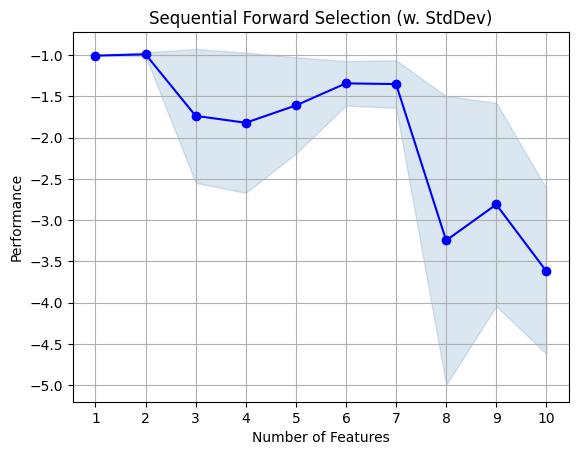

<Figure size 640x480 with 0 Axes>

In [34]:
# График отбора признаков для SFS
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
plt.savefig(f"../{FS_ASSETS_DIR}/sfs.png")

В этом случае также лучше взять максимум 6 признаков

In [36]:
sfs.k_feature_names_[:6]

('bin_cat__is_apartment_True',
 'bin_cat__has_elevator_True',
 'other_cat__rooms',
 'num_pipeline_wo_afr__num_pol__floor',
 'num_pipeline_wo_afr__num_pol__kitchen_area',
 'num_pipeline_wo_afr__num_pol__floor building_age')

__Обучаем модель на отобранных признаках__

Объединяем самые оптимальные признаки, отобранные с помощью SFFS и SFS, т.е. берем по 6 первых признаков от каждого метода, и получаем итоговый набор фич

In [40]:
selected_features_indices = list(set(sffs.k_feature_idx_[:6] + sfs.k_feature_idx_[:6]))

selected_encoded_X_train = encoded_X_train.iloc[:, selected_features_indices]
selected_encoded_X_test = encoded_X_test.iloc[:, selected_features_indices]

Обучаем модель

In [41]:
model = CatBoostRegressor(loss_function='MAPE', verbose=False, random_state=42)
model.fit(selected_encoded_X_train, y_train)

Оцениваем модель на тестовых данных

In [42]:
y_pred = model.predict(selected_encoded_X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

metrics = {}
metrics['MAPE'] = mape
metrics['fit_time'] = end - start
print(metrics)

{'MAPE': 1.0832110717976213, 'fit_time': 76.67032814025879}


__Логируем результаты в MLflow__

In [43]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 

TRACKING_SERVER_HOST = '127.0.0.1' 
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 

EXPERIMENT_NAME = 'mle-project-sprint-2'
RUN_NAME = 'step_4'
REGISTRY_MODEL_NAME = 'flats_price_model_sprint_2_step_4'

In [44]:
metadata = {'model_type': 'regression'}
pip_requirements = "../requirements.txt" 
signature = mlflow.models.infer_signature(
    selected_encoded_X_test,
    model.predict(selected_encoded_X_test)
) 
input_example = pd.concat([selected_encoded_X_train, y_train], axis=1)[:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(metrics)
    mlflow.log_artifacts(FS_ASSETS_DIR)
        
    model_info = mlflow.catboost.log_model( 
        cb_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        pip_requirements=pip_requirements
    )

2024-04-21 15:08:35,388 INFO: Found credentials in environment variables.
Successfully registered model 'flats_price_model_sprint_2_step_4'.
2024/04/21 15:08:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: flats_price_model_sprint_2_step_4, version 1
Created version '1' of model 'flats_price_model_sprint_2_step_4'.


In [45]:
print(run_id)

run = mlflow.get_run(run_id)
assert run.info.status == 'FINISHED'

c84a7a4fe4f545fa9589a40982a1704f


In [ ]:
# После логирования в MLflow удаляем файлы, сохраненные локально
os.remove(f'../{FS_ASSETS_DIR}/sffs.csv')
os.remove(f'../{FS_ASSETS_DIR}/sffs.png')

os.remove(f'../{FS_ASSETS_DIR}/sfs.csv')
os.remove(f'../{FS_ASSETS_DIR}/sfs.png')

__Выводы по результатам 4-го этапа:__
    
После обучения модели на признаках, отобранных с помощью методов SFFS и SFS, ошибка MAPE на тестовых данных снова заметно уменьшилась. Самыми важными признаками оказались is_apartment, has_elevator, rooms, floor, building_age и kitchen_area. Данные результаты отчасти согласуются с EDA.

### Этап 5: Подбор гиперпараметров и обучение новой версии модели <a id="step_5"></a>

Будем использовать признаки, преобразованные и отобранные на предыдущих этапах.

__Randomized Search__

In [54]:
model = CatBoostRegressor(
    loss_function='MAPE', 
    eval_metric='MAPE', 
    iterations=100,
    verbose=False,
    random_state=42
)

# Cетка параметров
params = {
    'learning_rate': np.logspace(-3, -1, 5), 
    'depth': [3, 4, 5, 6, 7],
    'l2_leaf_reg': np.logspace(-2, 0, 5)
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params, 
    scoring='neg_mean_absolute_percentage_error',
    n_iter=20, 
    cv=3, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(selected_encoded_X_train, y_train)
cv_results = pd.DataFrame(random_search.cv_results_)

In [55]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_l2_leaf_reg,param_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.014496,0.078710,0.013480,0.005886,0.031623,0.316228,3,"{'learning_rate': 0.03162277660168379, 'l2_lea...",-2.461355,-14.007178,-5.392424,-7.286986,4.900240,10
1,2.121253,0.030824,0.019488,0.003411,0.01,0.316228,4,"{'learning_rate': 0.01, 'l2_leaf_reg': 0.31622...",-2.429841,-15.962926,-4.054801,-7.482523,6.033134,11
2,2.098189,0.113464,0.023122,0.002274,0.003162,0.1,4,"{'learning_rate': 0.0031622776601683794, 'l2_l...",-0.992022,-6.366075,-2.051359,-3.136485,2.324254,3
3,2.553463,0.055356,0.025047,0.002498,0.003162,0.01,6,"{'learning_rate': 0.0031622776601683794, 'l2_l...",-1.243950,-8.112782,-2.533959,-3.963564,2.980832,6
4,2.340531,0.013043,0.028901,0.000300,0.031623,0.01,5,"{'learning_rate': 0.03162277660168379, 'l2_lea...",-2.932842,-21.001153,-9.492492,-11.142162,7.468022,17
5,2.332909,0.014478,0.022459,0.000649,0.003162,0.316228,6,"{'learning_rate': 0.0031622776601683794, 'l2_l...",-1.243921,-8.112782,-2.533959,-3.963554,2.980841,5
6,2.242677,0.157048,0.028315,0.005197,0.003162,0.031623,5,"{'learning_rate': 0.0031622776601683794, 'l2_l...",-1.016166,-8.018730,-2.092265,-3.709054,3.078905,4
7,2.932751,0.123028,0.026836,0.003421,0.031623,1.0,7,"{'learning_rate': 0.03162277660168379, 'l2_lea...",-2.846737,-21.922731,-13.692372,-12.820613,7.812100,19
8,2.657980,0.229130,0.022067,0.000525,0.031623,0.316228,6,"{'learning_rate': 0.03162277660168379, 'l2_lea...",-3.216136,-24.026169,-6.766222,-11.336175,9.089471,18
9,1.755048,0.164584,0.026250,0.004216,0.1,0.01,3,"{'learning_rate': 0.1, 'l2_leaf_reg': 0.01, 'd...",-2.553357,-21.136652,-3.750878,-9.146962,8.492075,13


In [56]:
best_params_random = random_search.best_params_ 
print(best_params_random)

best_score_random = random_search.best_score_
print(best_score_random)

{'learning_rate': 0.001, 'l2_leaf_reg': 0.1, 'depth': 3}
-1.0711496168994736


__Bayesian Search__

Устанавливаем уровень логирования в optuna

In [57]:
optuna.logging.set_verbosity(optuna.logging.INFO)

Целевая функция оптимизации для вычисления метрик на каждой итерации

In [94]:
def objective(trial: optuna.Trial) -> float:
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-4, 1, log=True)
    } 
       
    model = CatBoostRegressor(
        loss_function='MAPE', 
        eval_metric='MAPE', 
        iterations=300,
        random_state=42,
        verbose=False,
        **params
    )    
    skf = StratifiedKFold(n_splits=2) 
    metrics = defaultdict(list)

    for i, (train_index, val_index) in enumerate(skf.split(selected_encoded_X_train, y_train)):
        train_x = selected_encoded_X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = selected_encoded_X_train.iloc[val_index]
        val_y = y_train.iloc[val_index]
        
        model.fit(train_x, train_y)
        
        preds = model.predict(val_x)
        mape = mean_absolute_percentage_error(val_y, preds)
        metrics["mape"].append(mape)
        
    mape = median(metrics["mape"])
    
    return mape

Устанавливаем параметры MLflow

In [95]:
TRACKING_SERVER_HOST = "127.0.0.1" 
TRACKING_SERVER_PORT = 5000 

EXPERIMENT_NAME = 'mle-project-sprint-2' 
RUN_NAME = 'step_5' 
REGISTRY_MODEL_NAME = 'flats_price_model_sprint_2_step_5' 

os.environ["MLFLOW_S3_ENDPOINT_URL"] = 'https://storage.yandexcloud.net'
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "bayesian_search_step_5_test_3"

Запускаем поиск

In [ ]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as parent_run:
    parent_run_id = parent_run.info.run_id

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="MAPE",
    create_experiment=False,
    mlflow_kwargs={'experiment_id': experiment_id, 'tags': {MLFLOW_PARENT_RUN_ID: parent_run_id}}
)
    
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(),
    direction='minimize',
    study_name=STUDY_NAME,
    storage=STUDY_DB_NAME,
    load_if_exists=True
) 

study.optimize(objective, n_trials=10, callbacks=[mlflc]) 

In [97]:
# Лучшие метрики и параметры, найденные с помощью Optuna
best_score_optuna = study.best_value
best_params_optuna = study.best_params

print(f"Optuna best score: {best_score_optuna}")
print(f"Optuna best params: {best_params_optuna}")

Optuna best score: 1.1898707441780345
Optuna best params: {'learning_rate': 0.0010276475456092728, 'depth': 4, 'l2_leaf_reg': 0.08453478787278597}


Визуализируем результаты байевской оптимизации

In [101]:
# История изменений целевой метрики
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [102]:
# График важности гиперпараметров
fig = optuna.visualization.plot_param_importances(study)
fig.show()

__Выбираем и обучаем финальную модель__

Их двух методов лучшие метрики получились у случайного поиска, поэтому финальную модель обучаем на его гиперпараметрах

In [103]:
best_params = best_params_random

model = CatBoostRegressor(
    loss_function='MAPE', 
    random_state=42,
    verbose=False,
    **best_params
)

start = time.time()
model.fit(selected_encoded_X_train, y_train)
end = time.time()

Оцениваем модель на тестовых данных

In [104]:
y_pred = model.predict(selected_encoded_X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

metrics = {}
metrics['MAPE'] = mape
metrics['fit_time'] = end - start
print(metrics)

{'MAPE': 1.0018545020705296, 'fit_time': 11.433701753616333}


Логируем в MLflow финальную модель, ее метрики и другие артефакты

In [105]:
metadata = {'model_type': 'regression'}
pip_requirements = "../requirements.txt" 
signature = mlflow.models.infer_signature(
    selected_encoded_X_test,
    model.predict(selected_encoded_X_test)
) 
input_example = pd.concat([selected_encoded_X_train, y_train], axis=1)[:10]

with mlflow.start_run(run_id=parent_run_id) as run:
    mlflow.log_params(best_params)
    mlflow.log_metrics(metrics)
        
    model_info = mlflow.catboost.log_model(
        cb_model=model,
        artifact_path="models",
        await_registration_for=60,
        registered_model_name=REGISTRY_MODEL_NAME,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        pip_requirements=pip_requirements
    )

Successfully registered model 'flats_price_model_sprint_2_step_5'.
2024/04/21 16:46:05 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: flats_price_model_sprint_2_step_5, version 1
Created version '1' of model 'flats_price_model_sprint_2_step_5'.


In [106]:
print(parent_run_id)

run = mlflow.get_run(parent_run_id)
assert run.info.status == 'FINISHED'

59d04bca4276425aa0f6de46a69c868a


__Выводы по результатам 5-го этапа:__
    
С помощью подбора гиперпараметров снова удалось снизить ошибку MAPE на тестовых данных. Из двух примененных методов наилучшие результаты показал случайный поиск.